<a href="https://colab.research.google.com/github/losirlu1411/project-/blob/main/tuberculosis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This function is used for importing Libraries

In [1]:
### 1. Imports and Configuration
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import VGG16, DenseNet201, ResNet101
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


****

 I have used this function for  base_path = '/content/drive/MyDrive/project/TB_Chest_Radiography_Database’. It describes the location of data base located in google drive. It contains the label as normal, tuberculosis where input size of the image is described as224x224x3

In [2]:

# Dataset path
base_path = '/content/drive/MyDrive/project /TB_Chest_Radiography_Database'

# Class labels
labels = ['Normal', 'Tuberculosis']
image_size = 224

The below describes the no of cases in each folder. Using matplob.lib import library I have explained the cases on x-axis and no of cases on y-axis. As the no of cases in tuberculosis are less compared to normal cases

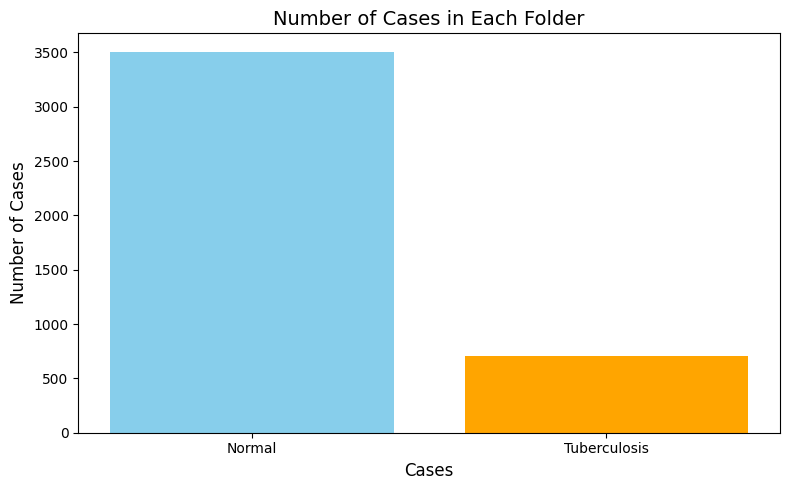

In [3]:
# Dictionary to store the count of cases per folder
case_counts = {}

labels = ['Normal', 'Tuberculosis']
# Count the number of files in each folder
for label in labels:
    folder_path = os.path.join(base_path, label)
    case_counts[label] = len(os.listdir(folder_path))


# Bar plot to visualize the number of cases
plt.figure(figsize=(8, 5))
# Use case_counts instead of cases_count
bars = plt.bar(case_counts.keys(), case_counts.values(), color=['skyblue', 'orange'])  # Different colors for each label

# Set plot title and labels
plt.title("Number of Cases in Each Folder", fontsize=14)
plt.xlabel("Cases", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

This Function is used for Count  no of cases in each folder using pie chart

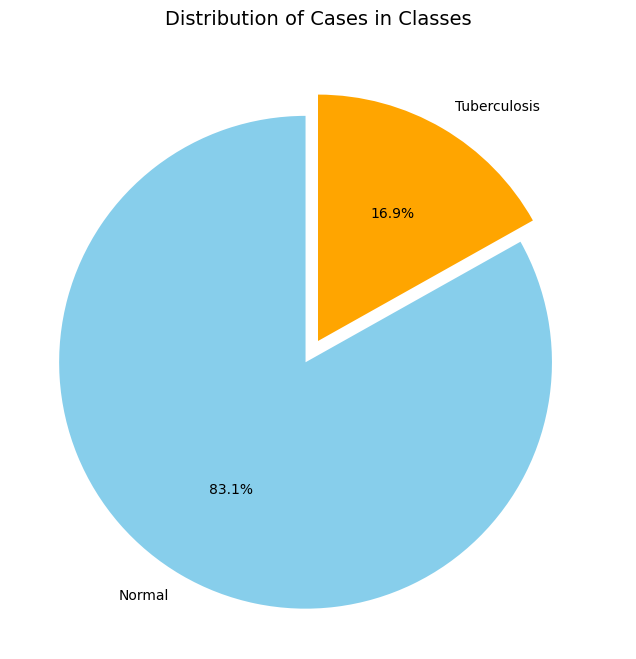

In [4]:
#Number of cases per class
cases_count = [len(os.listdir(os.path.join(base_path, label))) for label in labels]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    cases_count,
    labels=labels,  # Class names
    autopct='%1.1f%%',  # Show percentages
    startangle=90,  # Rotate the pie chart for better visualization
    colors=['skyblue', 'orange'],  # Assign colors
    explode=(0.1, 0)  # Slightly separate the first slice for emphasis
)

# Add a title
plt.title("Distribution of Cases in Classes", fontsize=14)
plt.show()

Data Loading and Processing: I have defined a function to load the images and preprocess images for machine learning. Below steps shows the code explanation:
1.Inputs:
•	Base-path: It is used for dataset directory
•	Labels: List of folder names.
•	Image size: It is used for resizing images to target size.
•	Sample_size: It used for loading no of images per class.
2.Process:
•	It will iterate through each class folder and randomly samples will load no of samples if specified or it will load all the samples.
•	It will read each image, resizes it and work along the data list corresponding to label index in label list.
3.Outputs:
It will return the data and label list. The function is used for ensuring the uniform image size.


In [6]:
### 2. Data Loading and Preprocessing
# Function to load and preprocess images with optional sampling
def load_data(base_path, labels, image_size, sample_size):
    data, label_list = [], []
    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(base_path, label)
        all_files = os.listdir(folder_path)
        if sample_size:
            sampled_files = random.sample(all_files, min(len(all_files), sample_size))
        else:
            sampled_files = all_files
        for file_name in sampled_files:
            img_path = os.path.join(folder_path, file_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            data.append(img)
            label_list.append(label_idx)
    return np.array(data), np.array(label_list)



Load dataset with all samples:
It will load all images data from each folder and divides pixel values by 255 to scale them between 0 and 1 using normalisation factor. One hot is used for converting the class labels. It will print the total no of images loaded after preprocessing


In [7]:
# Load dataset with all samples
print("Loading full dataset...")
x_data_full, y_data_full = load_data(base_path, labels, image_size,sample_size=None)
x_data_full = x_data_full / 255.0  # Normalize images
y_data_full = to_categorical(y_data_full, num_classes=len(labels))  # One-hot encode labels
print(f"Total images loaded: {len(x_data_full)}")



Loading full dataset...
Total images loaded: 4210


**Split into train and test set for the dataset: It uses sklearn learn used for splitting the train and test, x_data_full, y_data_full provide input data and corresponding labels, test size=0.2 it uses 20% of data used for testing and 80%for training and random states=42 it ensures reproducibility by fixing random split.**

In [8]:
# Split into train and test sets for both datasets
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_data_full, y_data_full, test_size=0.2, random_state=42)


Class weights and data augmentation:
1.Class weights: It calculates weights to balance the dataset to ensure the fair training.
2.Data Augmentation: It uses randomly modifies training images using rotations, shifts, zoom, and flips to increase data diversity. It applies the transformation using Image data generator and prepare the training data with train_datagen.fit(full).

In [9]:
### 3. Class Weights and Data Augmentation
# Compute class weights for both datasets
class_weights_full = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train_full, axis=1)),
    y=np.argmax(y_train_full, axis=1)
)
class_weights_dict_full = {i: weight for i, weight in enumerate(class_weights_full)}

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_datagen.fit(x_train_full)



Function to build a Custom CNN model:
1.Architecture: It allows the images of specified input shape, three convolutional 2d layers with increasing filters (32.64,128), each followed by max pooling 2d for down sampling. A flatten layer is used for converting 2d feature maps into 1d vectors, followed by dropout layer prevent overfitting by randomly deactivation 50% of neurons during training. Output layer is used for classifying into number of classes using SoftMax activation.
2.Compilation: Adam optimiser is used for adaptive learning rates, categorical Cross entropy with label smoothing 0.1 and metrics like accuracy and recall for performance evaluation.
Function to build pre trained models:
1. Pre trained base: It will use pre trained model like Vgg16, DenseNet 201, ResNet 101 and freeze its trainable layers. Flatten is used for converting features maps into a 1d vector, dense (256) uses fully connected layer using Relu activation, dropout (0.5) for prevent overfitting by 50% and output layer convert output to no of classes using soft max activation.
2.Compilation: Adam optimiser is used for learning, cross entropy with smooth labelling (0.1) and accuracy and recall metrics for evaluation.

In [10]:
### 4. Model Building
# Function to build a custom CNN model
def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

# Function to build pretrained models
def build_pretrained_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

Training and Evaluation Framework:
The code explains the function to train and evaluate model: In this early stop is introduced if the monitor validation performance and it will restore the best weights and stop training. It runs 20 epochs and validation for the test set. Verbose is used for displaying training progress and metrics.
Evaluation:
Forecasts probabilities on the test set (x_test) and translates them into class labels (y_pred).
Evaluates predictions against true labels (y_true) utilizing metrics such as a classification report and confusion matrix.

Visualization:
Exhibits a heatmap of the confusion matrix to illustrate model predictions.
Titles and labels enhance interpretability


In [11]:
### 5. Training and Evaluation Framework
# Function to train and evaluate model
def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, datagen, class_weights):
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_test, y_test),
        epochs=20,
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Evaluating {model_name}...")
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return history

Model Training:
Definition of Input:
• input_shape: Defines the dimensions of input images.
• num_classes: Denotes the aggregate number of categories for classification.

Custom CNN Model: A custom CNN is constructed and trained on the sampled dataset utilizing a data generator and class weights.
Pre-trained Models: VGG16, DenseNet201, and ResNet101 have been pre-trained on ImageNet and subsequently fine-tuned for the dataset through transfer learning.
The build_pretrained_model function incorporates task-specific layers into these models for classification purposes.
Training: Each model undergoes training and evaluation through train_and_evaluate_model, utilizing the sampled training (x_train_full, y_train_full) and test datasets (x_test_full, y_test_full).


Training Custom CNN (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 354ms/step - accuracy: 0.6855 - loss: 0.6641 - recall: 0.5815 - val_accuracy: 0.9074 - val_loss: 0.4141 - val_recall: 0.6058
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.8444 - loss: 0.5592 - recall: 0.6341 - val_accuracy: 0.9394 - val_loss: 0.3503 - val_recall: 0.7883
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.8936 - loss: 0.4144 - recall: 0.8100 - val_accuracy: 0.9287 - val_loss: 0.3296 - val_recall: 0.8102
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.8720 - loss: 0.4202 - recall: 0.8285 - val_accuracy: 0.9133 - val_loss: 0.3637 - val_recall: 0.9197
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.8893 - loss: 0.3863 - recall: 0.8711 - val_accuracy: 0.9561 - val_loss: 0.3203 - val_recall: 0.8029
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.8889 - loss: 0.4199 - recall: 0.8451 - val_accuracy: 0.9537 - val_loss: 0.3998 - val_recall: 0.79

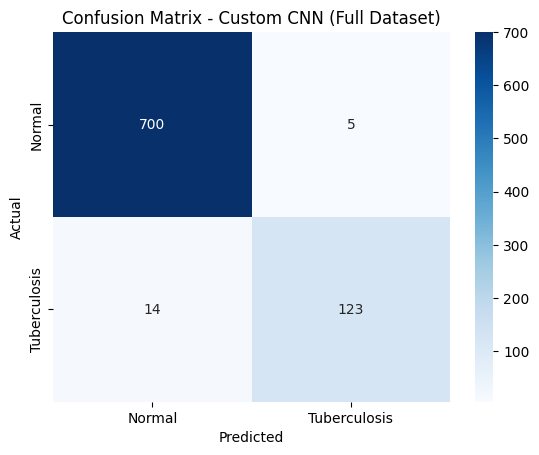

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training VGG16 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 345ms/step - accuracy: 0.7072 - loss: 1.5170 - recall: 0.7090 - val_accuracy: 0.9751 - val_loss: 0.2635 - val_recall: 0.8759
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.8899 - loss: 0.3888 - recall: 0.8731 - val_accuracy: 0.9572 - val_loss: 0.2809 - val_recall: 0.9562
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 296ms/step - accuracy: 0.9081 - loss: 0.3767 - recall: 0.9001 - val_accuracy: 0.9679 - val_loss: 0.2677 - val_recall: 0.9635
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.9212 - loss: 0.3484 - recall: 0.9106 - val_accuracy: 0.9679 - val_loss: 0.2795 - val_recall: 0.9708
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.9274 - loss: 0.3373 - recall: 0.9215 - val_accuracy: 0.9834 - val_loss: 0.2631 - val_recall: 0.9635
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.9392 - loss: 0.3429 - recall: 0.9169 - val_accuracy: 0.9359 - val_loss: 0.3134 - val_recall: 0.98

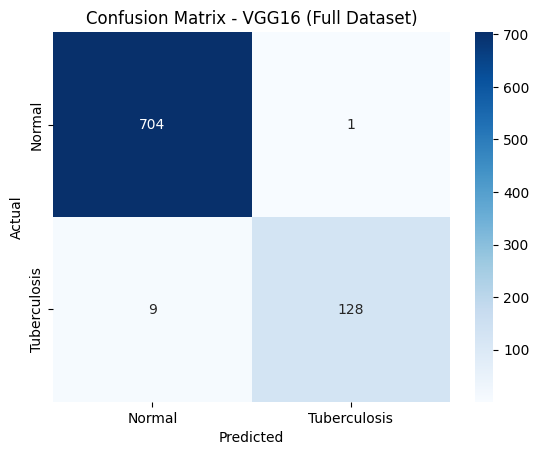

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training DenseNet201 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 120s 744ms/step - accuracy: 0.7640 - loss: 5.5906 - recall: 0.7340 - val_accuracy: 0.9632 - val_loss: 0.3073 - val_recall: 0.7737
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 303ms/step - accuracy: 0.9332 - loss: 0.3751 - recall: 0.8891 - val_accuracy: 0.9739 - val_loss: 0.2594 - val_recall: 0.8467
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 308ms/step - accuracy: 0.9423 - loss: 0.3346 - recall: 0.9319 - val_accuracy: 0.9917 - val_loss: 0.2427 - val_recall: 0.9562
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - accuracy: 0.9481 - loss: 0.3225 - recall: 0.9540 - val_accuracy: 0.9917 - val_loss: 0.2424 - val_recall: 0.9562
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 304ms/step - accuracy: 0.9438 - loss: 0.3175 - recall: 0.9371 - val_accuracy: 0.9822 - val_loss: 0.2827 - val_recall: 0.8905
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 308ms/step - accuracy: 0.9612 - loss: 0.3054 - recall: 0.9656 - val_accuracy: 0.9917 - val_loss: 0.2373 - val_recall: 0.9

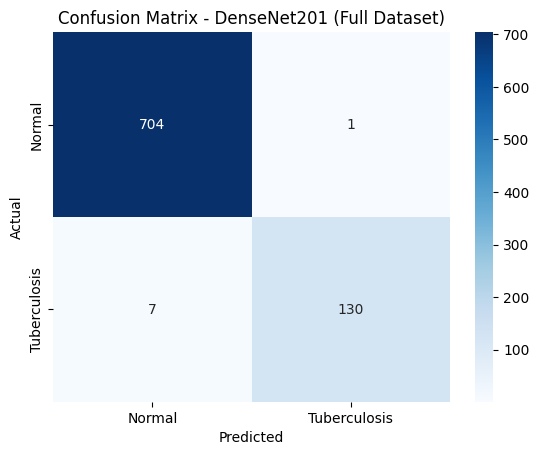

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Training ResNet101 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 68s 449ms/step - accuracy: 0.5043 - loss: 5.0971 - recall: 0.4939 - val_accuracy: 0.2209 - val_loss: 0.7058 - val_recall: 1.0000
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 301ms/step - accuracy: 0.4127 - loss: 0.6957 - recall: 0.6631 - val_accuracy: 0.8385 - val_loss: 0.6899 - val_recall: 0.0073
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - accuracy: 0.7602 - loss: 0.7067 - recall: 0.1578 - val_accuracy: 0.8361 - val_loss: 0.6871 - val_recall: 0.0219
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.8307 - loss: 0.6920 - recall: 0.0000e+00 - val_accuracy: 0.8385 - val_loss: 0.6891 - val_recall: 0.0073
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 299ms/step - accuracy: 0.7979 - loss: 0.7004 - recall: 0.0611 - val_accuracy: 0.8385 - val_loss: 0.6906 - val_recall: 0.0073
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.8334 - loss: 0.6874 - recall: 0.0000e+00 - val_accuracy: 0.8385 - val_loss: 0.6895 - val_reca

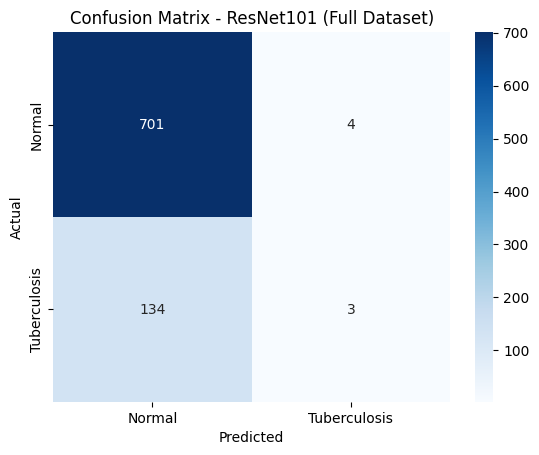

In [12]:
### 6. Model Training
# Define input shape and number of classes
input_shape = (image_size, image_size, 3)
num_classes = len(labels)

# Custom Model
custom_model_full = build_custom_model(input_shape, num_classes)
custom_history_full = train_and_evaluate_model(custom_model_full, "Custom CNN (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)


# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_model_full = build_pretrained_model(vgg16_base, input_shape, num_classes)
vgg16_history_full = train_and_evaluate_model(vgg16_model_full, "VGG16 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)

# DenseNet201
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model_full = build_pretrained_model(densenet_base, input_shape, num_classes)
densenet_history_full = train_and_evaluate_model(densenet_model_full, "DenseNet201 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)

# ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model_full = build_pretrained_model(resnet_base, input_shape, num_classes)
resnet_history_full = train_and_evaluate_model(resnet_model_full, "ResNet101 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)


This code plots the training and validation accuracy and loss for four models (`Custom CNN`, `VGG16`, `DenseNet201`, `ResNet101`) across epochs. For each model:

1. **Accuracy Plot (Left)**: Shows how training and validation accuracy change over epochs.
2. **Loss Plot (Right)**: Displays how training and validation loss evolve over epochs.

Each model's performance is visualized in separate figures to compare their learning behavior.

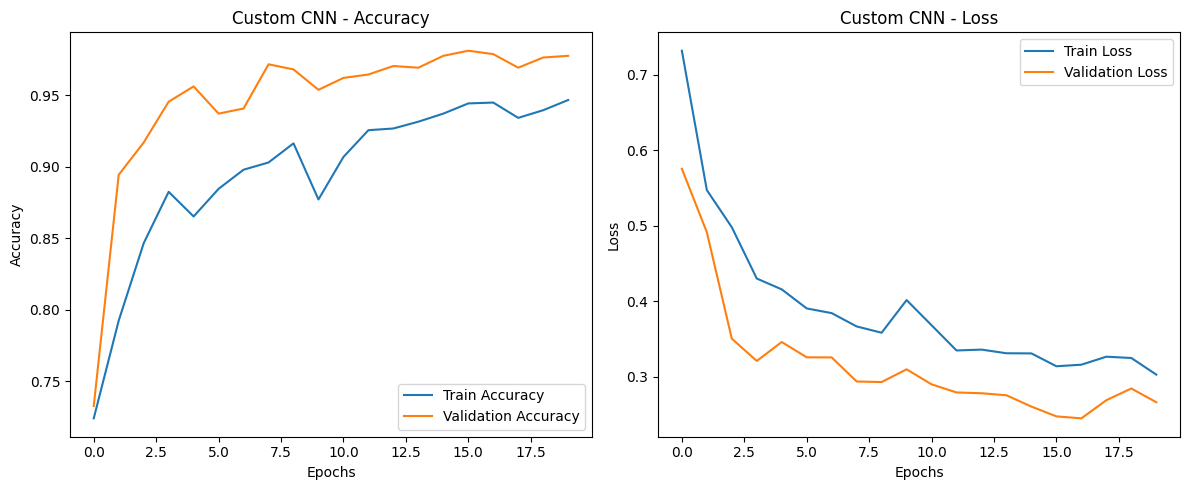

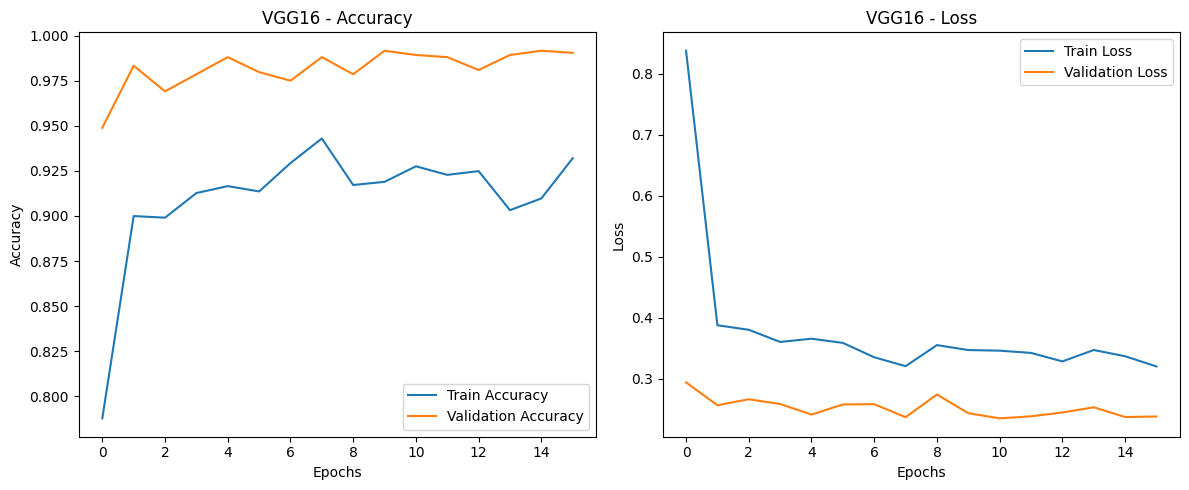

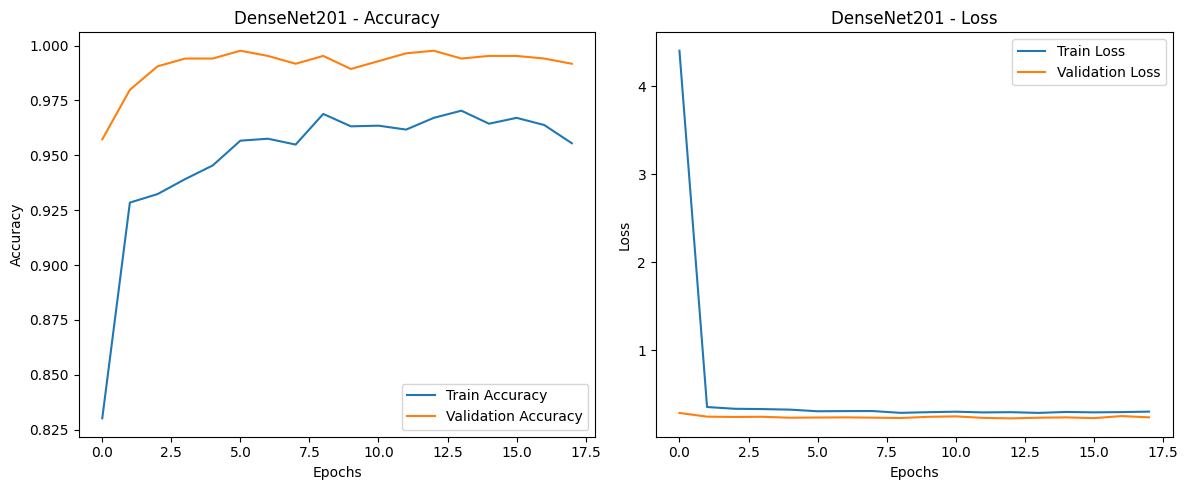

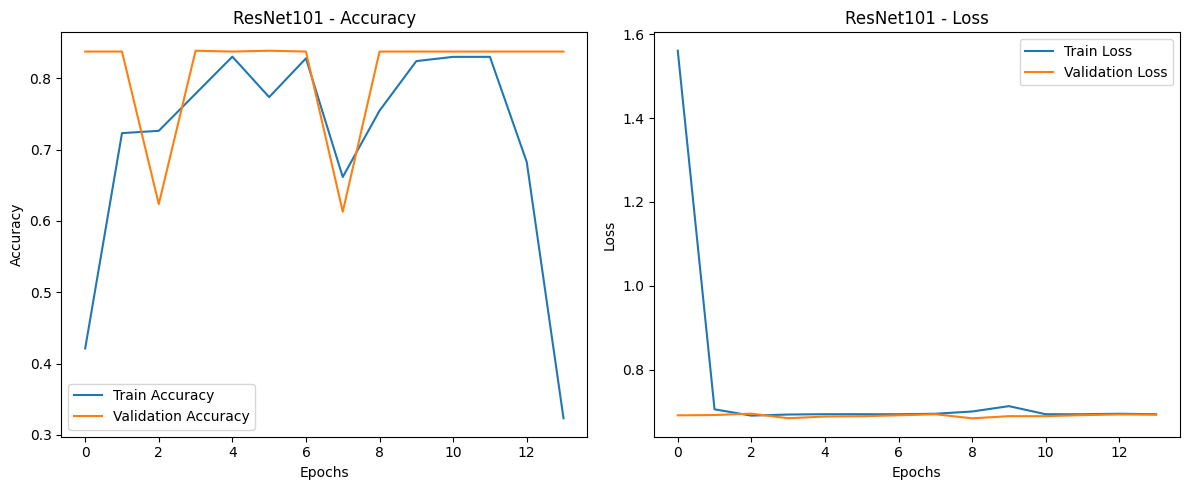

In [ ]:
# 7 Plot individual models
models = {
    "Custom CNN": custom_history_full,
    "VGG16": vgg16_history_full,
    "DenseNet201": densenet_history_full,
    "ResNet101": resnet_history_full,

}

for model_name, history in models.items():
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Predict and Display Images: It is used for displaying prediction made by model by selecting random images: It will use random images from the predicted model. It will display the true label and predicted model highlight them in green for correct prediction and red for wrong predictions.

Predictions for Full Dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


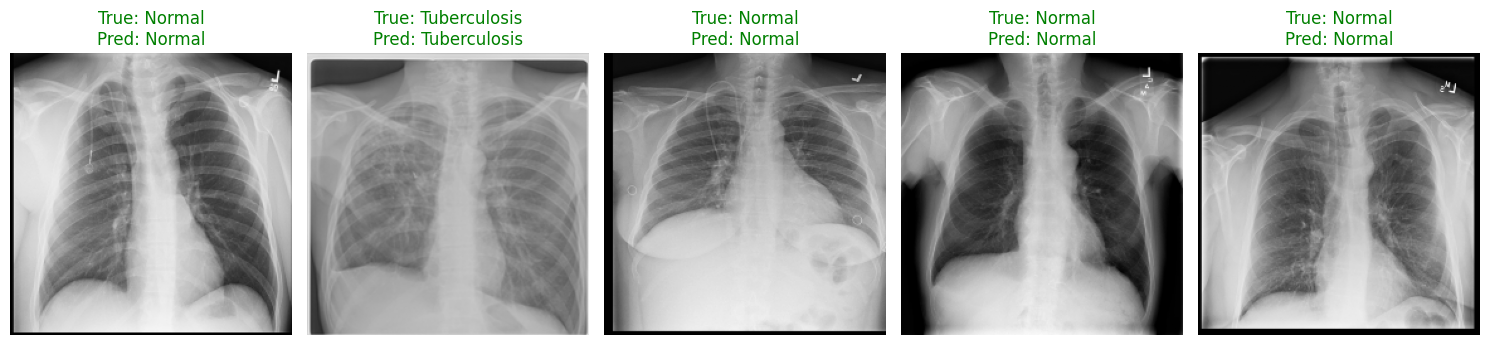

In [ ]:
### 8. Predict and Display Images
# Function to display predictions for 5 random images
def display_predictions(model, x_test, y_test, labels, num_images=5):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = x_test[idx]
        true_label = labels[np.argmax(y_test[idx])]
        pred_label = labels[np.argmax(model.predict(img[np.newaxis, ...]))]
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
print("Predictions for Full Dataset")
display_predictions(custom_model_full, x_test_full, y_test_full, labels, num_images=5)


This code evaluates and compares the performance of four models (VGG16, ResNet101, Custom CNN, and DenseNet201) on the test dataset using metrics such as Accuracy, Precision, Recall, and F1-Score.

Predictions:

Each model makes predictions on the test dataset (x_test_full), and the predicted class labels are determined using np.argmax.
Evaluation Function:

The evaluate_model function calculates performance metrics for a model:
Accuracy: Overall correctness of predictions.
Precision: Proportion of correctly predicted positives.
Recall: Proportion of actual positives correctly identified.
F1-Score: Harmonic mean of precision and recall.
Results Aggregation:

The evaluation results for all models are stored in a list of dictionaries, converted into a Pandas DataFrame for tabular comparison.
Visualization:

A bar plot is generated to visually compare the performance of the models based on the metrics.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
         Model  Accuracy  Precision    Recall  F1-Score
0        VGG16  0.989311   0.989285  0.989311  0.989295
1    ResNet101  0.837292   0.701058  0.837292  0.763143
2   Custom CNN  0.978622   0.978578  0.978622  0.978223
3  DenseNet201  0.997625   0.997631  0.997625  0.997618


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


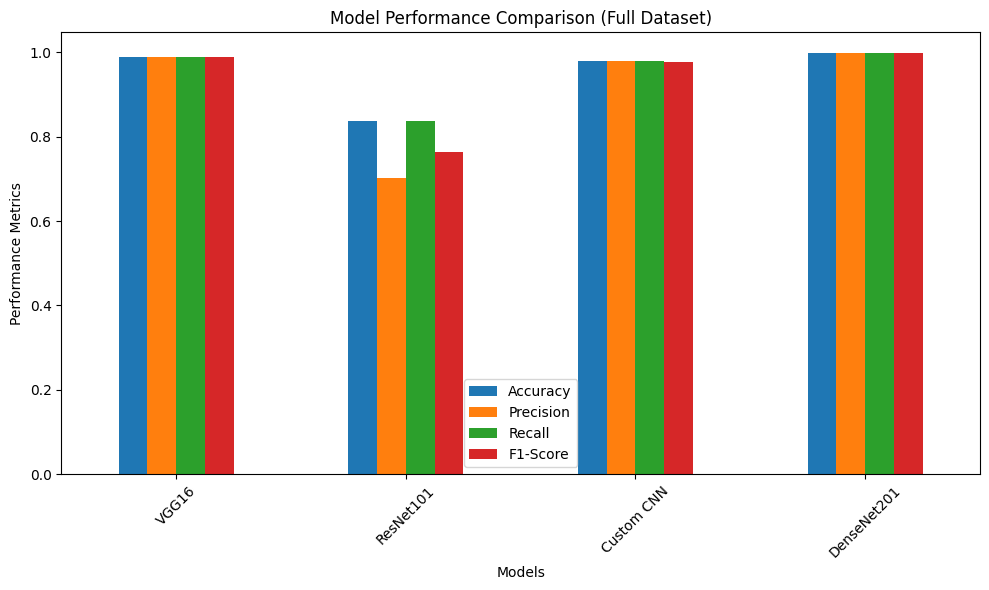

In [ ]:
# 9 Predictions for each individual model

vgg_preds_full = np.argmax(vgg16_model_full.predict(x_test_full), axis=1)
resnet_preds_full = np.argmax(resnet_model_full.predict(x_test_full), axis=1)
custom_preds_full = np.argmax(custom_model_full.predict(x_test_full), axis=1)
densenet_preds_full = np.argmax(densenet_model_full.predict(x_test_full), axis=1)

# True labels
y_true_full = np.argmax(y_test_full, axis=1)



# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

# Evaluate models for the full dataset
results_full = []
results_full.append(evaluate_model(y_true_full, vgg_preds_full, "VGG16"))
results_full.append(evaluate_model(y_true_full, resnet_preds_full, "ResNet101"))
results_full.append(evaluate_model(y_true_full, custom_preds_full, "Custom CNN"))
results_full.append(evaluate_model(y_true_full, densenet_preds_full, "DenseNet201"))

# Convert results to DataFrames for comparison
results_full_df = pd.DataFrame(results_full)

# Display the results
print(results_full_df)

# Bar plot for the full dataset
results_full_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (Full Dataset)")
plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()



Load dataset with 500 samples:
It will load all images data from each folder and divides pixel values by 255 to scale them between 0 and 1 using normalisation factor. One hot is used for converting the class labels. It will print the total no of images loaded after preprocessing.


In [13]:
# Load dataset with 500 samples per class
print("Loading sampled dataset (500 per class)...")
x_data_sampled, y_data_sampled = load_data(base_path, labels, image_size, sample_size=500)
x_data_sampled = x_data_sampled / 255.0  # Normalize images
y_data_sampled = to_categorical(y_data_sampled, num_classes=len(labels))  # One-hot encode labels
print(f"Total images loaded: {len(x_data_sampled)}")

Loading sampled dataset (500 per class)...
Total images loaded: 1000


Split into train and test set for the dataset: It uses sklearn learn used for splitting the train and test, x_data_sampled, y_data_sampled provide input data and corresponding labels, test size=0.2 it uses 20% of data used for testing and 80%for training and random states=42 it ensures reproducibility by fixing random split.

In [14]:
# Split into train and test sets for both datasets
x_train_sampled, x_test_sampled, y_train_sampled, y_test_sampled = train_test_split(x_data_sampled, y_data_sampled, test_size=0.2, random_state=42)

Class weights and data augmentation:
1.Class weights: It calculates weights to balance the dataset to ensure the fair training.
2.Data Augmentation: It uses randomly modifies training images using rotations, shifts, zoom, and flips to increase data diversity. It applies the transformation using Image data generator and prepare the training data with train_datagen.fit(sample).

In [15]:
### 3. Class Weights and Data Augmentation
# Compute class weights for both datasets

class_weights_sampled = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train_sampled, axis=1)),
    y=np.argmax(y_train_sampled, axis=1)
)
class_weights_dict_sampled = {i: weight for i, weight in enumerate(class_weights_sampled)}

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_datagen.fit(x_train_sampled)

Function to build a Custom CNN model:
1.Architecture: It allows the images of specified input shape, three convolutional 2d layers with increasing filters (32.64,128), each followed by max pooling 2d for down sampling. A flatten layer is used for converting 2d feature maps into 1d vectors, followed by dropout layer prevent overfitting by randomly deactivation 50% of neurons during training. Output layer is used for classifying into number of classes using SoftMax activation.
2.Compilation: Adam optimiser is used for adaptive learning rates, categorical Cross entropy with label smoothing 0.1 and metrics like accuracy and recall for performance evaluation.


Function to build pre trained models:
1. Pre trained base: It will use pre trained model like Vgg16, DenseNet 201, ResNet 101 and freeze its trainable layers. Flatten is used for converting features maps into a 1d vector, dense (256) uses fully connected layer using Relu activation, dropout (0.5) for prevent overfitting by 50% and output layer convert output to no of classes using soft max activation.
2.Compilation: Adam optimiser is used for learning, cross entropy with smooth labelling (0.1) and accuracy and recall metrics for evaluation.


In [16]:
### 4. Model Building
# Function to build a custom CNN model
def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        # Changed the third Conv2D layer configuration from 128 filters with (3,3) kernel to 64 filters with (3,3) kernel.
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

# Function to build pretrained models
def build_pretrained_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

Training and Evaluation Framework:
The code explains the function to train and evaluate model: In this early stop is introduced if the monitor validation performance and it will restore the best weights and stop training. It runs 20 epochs and validation for the test set. Verbose is used for displaying training progress and metrics
Evaluation:
Forecasts probabilities on the test set (x_test) and translates them into class labels (y_pred).
Evaluates predictions against true labels (y_true) utilizing metrics such as a classification report and confusion matrix.

Visualization:
Exhibits a heatmap of the confusion matrix to illustrate model predictions.
Titles and labels enhance interpretability.

In [17]:
### 5. Training and Evaluation Framework
# Function to train and evaluate model
def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, datagen, class_weights):
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_test, y_test),
        epochs=20,
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Evaluating {model_name}...")
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return history

Custom CNN Model: A custom CNN is constructed and trained on the sampled dataset utilizing a data generator and class weights.
Pre-trained Models: VGG16, DenseNet201, and ResNet101 have been pre-trained on ImageNet and subsequently fine-tuned for the dataset through transfer learning.
The build_pretrained_model function incorporates task-specific layers into these models for classification purposes.
Training: Each model undergoes training and evaluation through train_and_evaluate_model, utilizing the sampled training (x_train_sampled, y_train_sampled) and test datasets (x_test_sampled, y_test_sampled).

Training Custom CNN (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - accuracy: 0.5318 - loss: 1.8063 - recall: 0.5540 - val_accuracy: 0.6600 - val_loss: 0.5851 - val_recall: 0.3462
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.7456 - loss: 0.5518 - recall: 0.5199 - val_accuracy: 0.7700 - val_loss: 0.5143 - val_recall: 0.6154
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.8030 - loss: 0.5051 - recall: 0.7109 - val_accuracy: 0.8300 - val_loss: 0.4788 - val_recall: 0.7212
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.7895 - loss: 0.4994 - recall: 0.7946 - val_accuracy: 0.7650 - val_loss: 0.4846 - val_recall: 0.5577
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.8003 - loss: 0.4697 - recall: 0.7460 - val_accuracy: 0.7500 - val_loss: 0.5595 - val_recall: 0.5577
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.8197 - loss: 0.4822 - recall: 0.8280 - val_accuracy: 0.7800 - val_loss: 0.4697 - val_recall: 0.5865
Epoch 7/20
25/

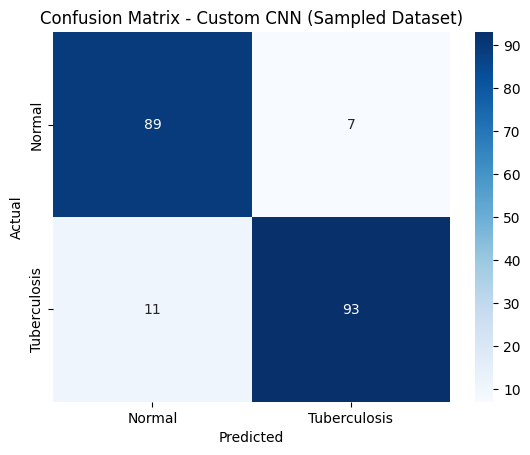

Training VGG16 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step - accuracy: 0.5785 - loss: 2.7880 - recall: 0.6034 - val_accuracy: 0.8900 - val_loss: 0.3947 - val_recall: 0.9038
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.8580 - loss: 0.4266 - recall: 0.8693 - val_accuracy: 0.9300 - val_loss: 0.3376 - val_recall: 0.9519
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.8822 - loss: 0.4021 - recall: 0.8753 - val_accuracy: 0.9050 - val_loss: 0.3545 - val_recall: 0.9712
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9130 - loss: 0.3522 - recall: 0.9358 - val_accuracy: 0.9400 - val_loss: 0.3137 - val_recall: 0.9615
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9167 - loss: 0.3434 - recall: 0.9217 - val_accuracy: 0.9250 - val_loss: 0.3272 - val_recall: 0.9712
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.9041 - loss: 0.3616 - recall: 0.8953 - val_accuracy: 0.9600 - val_loss: 0.2964 - val_recall: 0.9423
Epoch 7/20
25/

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
Classification Report for VGG16 (Sampled Dataset):
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98        96
Tuberculosis       0.99      0.98      0.99       104

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200



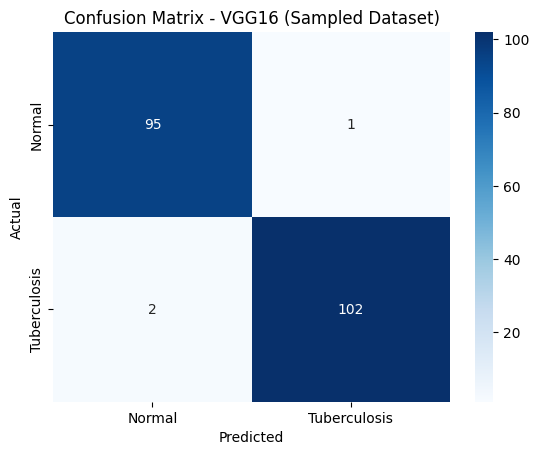

Training DenseNet201 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6930 - loss: 7.6133 - recall: 0.6677 - val_accuracy: 0.9500 - val_loss: 0.6797 - val_recall: 0.9038
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.8957 - loss: 0.7179 - recall: 0.8724 - val_accuracy: 0.9450 - val_loss: 0.3467 - val_recall: 0.9038
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.9190 - loss: 0.3715 - recall: 0.9100 - val_accuracy: 0.9600 - val_loss: 0.2922 - val_recall: 0.9231
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.9036 - loss: 0.3729 - recall: 0.8916 - val_accuracy: 0.9800 - val_loss: 0.2604 - val_recall: 0.9712
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.9294 - loss: 0.3474 - recall: 0.9331 - val_accuracy: 0.9900 - val_loss: 0.2535 - val_recall: 0.9904
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.9512 - loss: 0.3287 - recall: 0.9557 - val_accuracy: 0.9850 - val_loss: 0.2548 - val_recall: 0.9808
Epoch 7/20
25/25

7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Classification Report for DenseNet201 (Sampled Dataset):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99        96
Tuberculosis       0.99      0.99      0.99       104

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



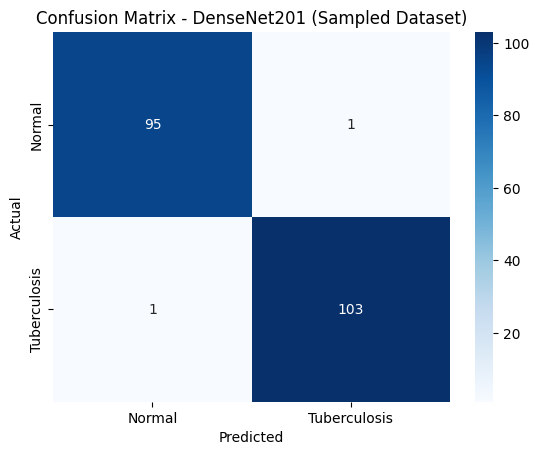

Training ResNet101 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 648ms/step - accuracy: 0.5603 - loss: 5.1886 - recall: 0.5254 - val_accuracy: 0.5200 - val_loss: 1.0043 - val_recall: 1.0000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.4714 - loss: 0.8884 - recall: 0.5443 - val_accuracy: 0.5200 - val_loss: 0.6917 - val_recall: 1.0000
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.5192 - loss: 0.6942 - recall: 1.0000 - val_accuracy: 0.5200 - val_loss: 0.6908 - val_recall: 1.0000
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.5136 - loss: 0.6920 - recall: 0.4685 - val_accuracy: 0.5200 - val_loss: 0.6900 - val_recall: 1.0000
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.5505 - loss: 0.6914 - recall: 0.4959 - val_accuracy: 0.6750 - val_loss: 0.6894 - val_recall: 0.7692
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.5280 - loss: 0.6917 - recall: 0.1319 - val_accuracy: 0.5500 - val_loss: 0.6917 - val_recall: 0.1731
Epoch 7/20
25/

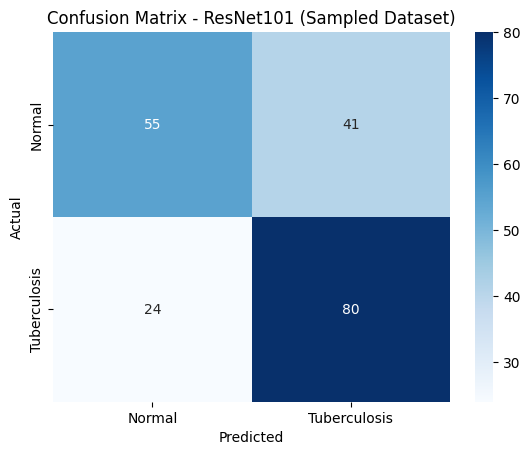

In [18]:
### 6. Model Training
# Define input shape and number of classes
input_shape = (image_size, image_size, 3)
num_classes = len(labels)

# Custom Model
custom_model_sampled = build_custom_model(input_shape, num_classes)
custom_history_sampled = train_and_evaluate_model(custom_model_sampled, "Custom CNN (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_model_sampled = build_pretrained_model(vgg16_base, input_shape, num_classes)
vgg16_history_sampled = train_and_evaluate_model(vgg16_model_sampled, "VGG16 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# DenseNet201
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model_sampled = build_pretrained_model(densenet_base, input_shape, num_classes)
densenet_history_sampled = train_and_evaluate_model(densenet_model_sampled, "DenseNet201 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model_sampled = build_pretrained_model(resnet_base, input_shape, num_classes)
resnet_history_sampled = train_and_evaluate_model(resnet_model_sampled, "ResNet101 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

This code plots the training and validation accuracy and loss for four models (`Custom CNN`, `VGG16`, `DenseNet201`, `ResNet101`) across epochs. For each model:

1. **Accuracy Plot (Left)**: Shows how training and validation accuracy change over epochs.
2. **Loss Plot (Right)**: Displays how training and validation loss evolve over epochs.

Each model's performance is visualized in separate figures to compare their learning behavior.

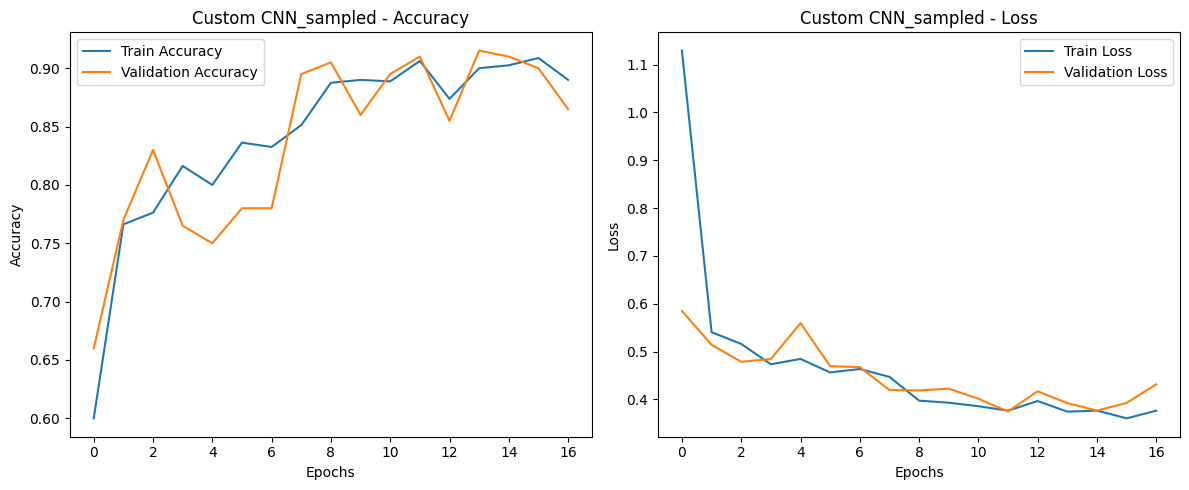

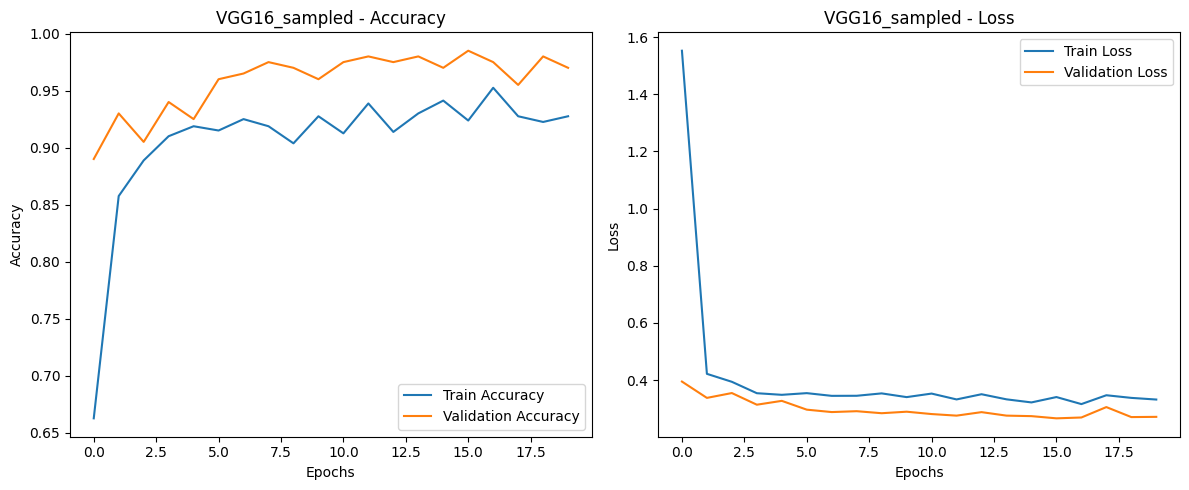

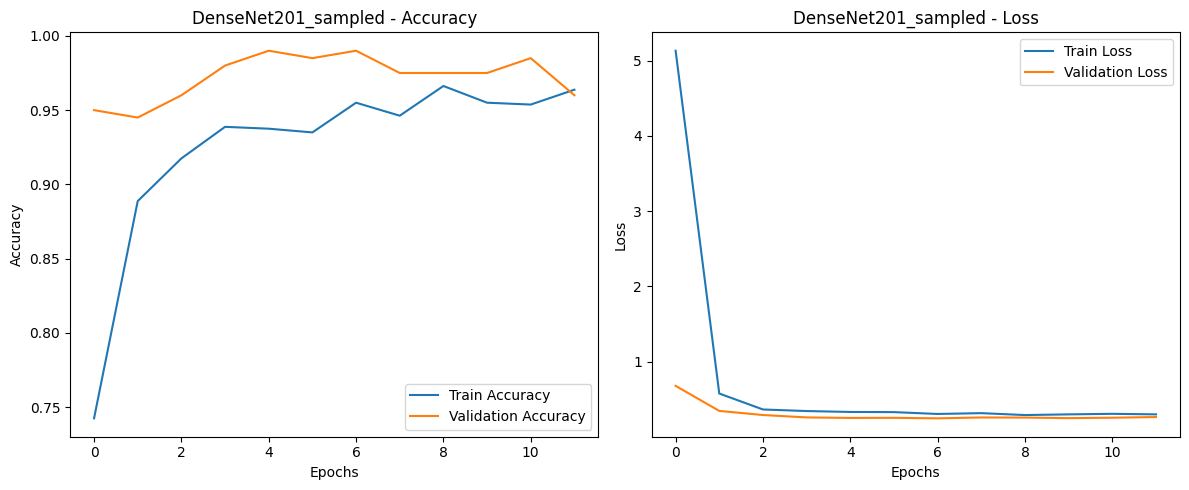

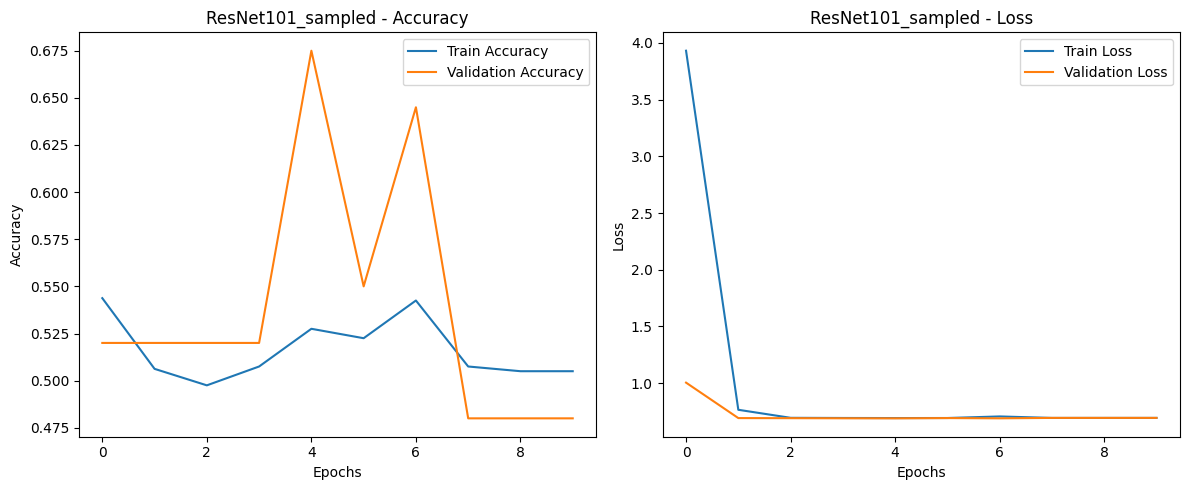

In [19]:
# 7 Plot individual models
models = {
    "Custom CNN_sampled": custom_history_sampled,
    "VGG16_sampled": vgg16_history_sampled,
    "DenseNet201_sampled": densenet_history_sampled,
    "ResNet101_sampled": resnet_history_sampled
}

for model_name, history in models.items():
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Predict and Display Images: It is used for displaying prediction made by model by selecting random images: It will use random images from the predicted model. It will display the true label and predicted model highlight them in green for correct prediction and red for wrong predictions.

Predictions for Sampled Dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


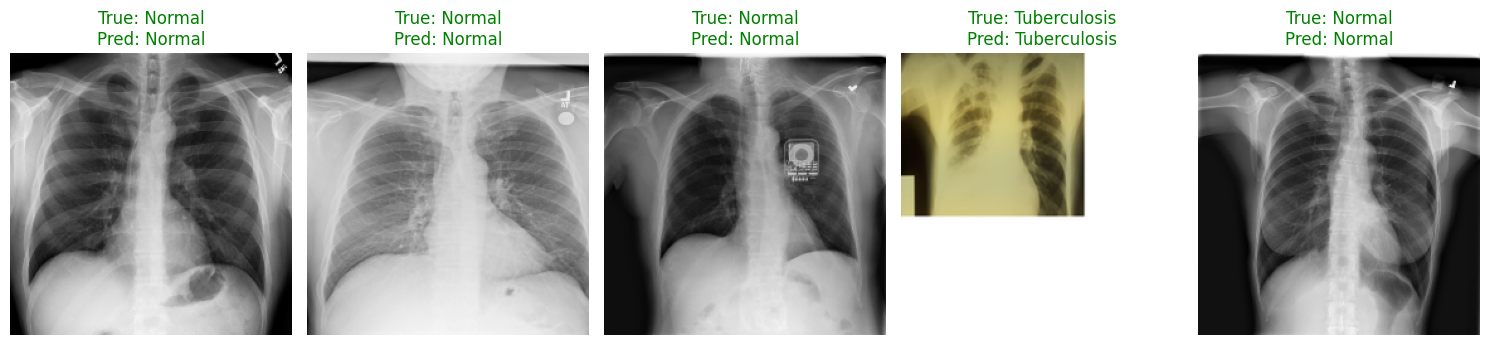

In [20]:
### 8. Predict and Display Images
# Function to display predictions for 5 random images
def display_predictions(model, x_test, y_test, labels, num_images=5):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = x_test[idx]
        true_label = labels[np.argmax(y_test[idx])]
        pred_label = labels[np.argmax(model.predict(img[np.newaxis, ...]))]
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
print("Predictions for Sampled Dataset")
display_predictions(custom_model_sampled, x_test_sampled, y_test_sampled, labels, num_images=5)


This code evaluates and compares the performance of four models (VGG16, ResNet101, Custom CNN, and DenseNet201) on the test dataset using metrics such as Accuracy, Precision, Recall, and F1-Score.

Predictions:

Each model makes predictions on the test dataset (x_test_sample), and the predicted class labels are determined using np.argmax.
Evaluation Function:

The evaluate_model function calculates performance metrics for a model:
Accuracy: Overall correctness of predictions.
Precision: Proportion of correctly predicted positives.
Recall: Proportion of actual positives correctly identified.
F1-Score: Harmonic mean of precision and recall.
Results Aggregation:

The evaluation results for all models are stored in a list of dictionaries, converted into a Pandas DataFrame for tabular comparison.
Visualization:

A bar plot is generated to visually compare the performance of the models based on the metrics.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
         Model  Accuracy  Precision  Recall  F1-Score
0        VGG16     0.985   0.985055   0.985  0.985003
1    ResNet101     0.675   0.677979   0.675  0.671492
2   Custom CNN     0.910   0.910800   0.910  0.910036
3  DenseNet201     0.990   0.990000   0.990  0.990000


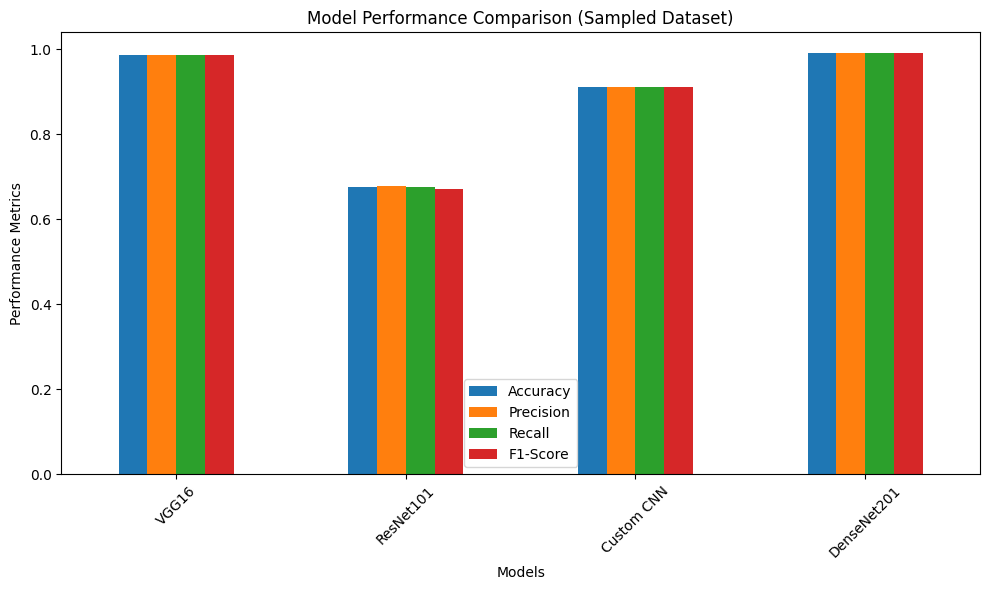

In [21]:
# 9 Predictions for each individual model
vgg_preds_sampled = np.argmax(vgg16_model_sampled.predict(x_test_sampled), axis=1)
resnet_preds_sampled = np.argmax(resnet_model_sampled.predict(x_test_sampled), axis=1)
custom_preds_sampled = np.argmax(custom_model_sampled.predict(x_test_sampled), axis=1)
densenet_preds_sampled = np.argmax(densenet_model_sampled.predict(x_test_sampled), axis=1)

# True labels
y_true_sampled = np.argmax(y_test_sampled, axis=1)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}



# Evaluate models for the sampled dataset
results_sampled = []
results_sampled.append(evaluate_model(y_true_sampled, vgg_preds_sampled, "VGG16"))
results_sampled.append(evaluate_model(y_true_sampled, resnet_preds_sampled, "ResNet101"))
results_sampled.append(evaluate_model(y_true_sampled, custom_preds_sampled, "Custom CNN"))
results_sampled.append(evaluate_model(y_true_sampled, densenet_preds_sampled, "DenseNet201"))


# Convert results to DataFrames for comparison
results_sampled_df = pd.DataFrame(results_sampled)
print(results_sampled_df)
# Bar plot for the sampled dataset
results_sampled_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (Sampled Dataset)")
plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()
